# Set up

In [5]:
import xlwings as xw
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import seaborn as sns

Set up Regression data (can skip to regression, just FYI on the data preparation)

In [6]:
wb = xw.Book("/Users/justin/Documents/FI/Research notebooks/Fed_hike_regression.xlsm")
reg_data = wb.sheets[0]

In [7]:
df1 = pd.DataFrame(reg_data.range('A1').expand().value)
df1.columns = df1.iloc[0]
df1 = df1.drop(df1.index[0])
econ_indicators = ["Core inflation (YoY % chg)", "Nonfarm payroll change (MoM chg in thousand)", "Unemployment (YoY % chg)", "PCE (YoY % chg)", "Consumer Confidence"]
num_cols = df1.columns[1:]
df1[num_cols] = df1[num_cols].apply(pd.to_numeric, errors='coerce')
print(df1)

0                   Date  Fed Funds  Rate Hike  Core inflation (YoY % chg)   
1    2000-02-01 00:00:00       5.73       0.28                       0.027  \
2    2000-03-01 00:00:00       5.85       0.12                       0.032   
3    2000-04-01 00:00:00       6.02       0.17                       0.038   
4    2000-05-01 00:00:00       6.27       0.25                       0.031   
5    2000-06-01 00:00:00       6.53       0.26                       0.032   
..                   ...        ...        ...                         ...   
276  2023-01-01 00:00:00       4.33       0.23                       0.065   
277  2023-02-01 00:00:00       4.57       0.24                       0.064   
278  2023-03-01 00:00:00       4.65       0.08                       0.060   
279  2023-04-01 00:00:00       4.83       0.18                       0.050   
280  2023-05-01 00:00:00       5.08       0.25                       0.049   

0    Nonfarm payroll change (MoM chg in thousand)  Unemployment

Forecast data amount

In [8]:
forecast_set = 6
df_training = df1[:-forecast_set]
df_forecast = df1[-forecast_set:]
print(df_training)

0                   Date  Fed Funds  Rate Hike  Core inflation (YoY % chg)   
1    2000-02-01 00:00:00       5.73       0.28                       0.027  \
2    2000-03-01 00:00:00       5.85       0.12                       0.032   
3    2000-04-01 00:00:00       6.02       0.17                       0.038   
4    2000-05-01 00:00:00       6.27       0.25                       0.031   
5    2000-06-01 00:00:00       6.53       0.26                       0.032   
..                   ...        ...        ...                         ...   
270  2022-07-01 00:00:00       1.68       0.47                       0.091   
271  2022-08-01 00:00:00       2.33       0.65                       0.085   
272  2022-09-01 00:00:00       2.56       0.23                       0.083   
273  2022-10-01 00:00:00       3.08       0.52                       0.082   
274  2022-11-01 00:00:00       3.78       0.70                       0.077   

0    Nonfarm payroll change (MoM chg in thousand)  Unemployment

# Regression

In [9]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

Use default random forest as an example

In [10]:
x = df_training[econ_indicators]
y = df_training['Rate Hike']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse_lr = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE: ', mse_lr)
print('R2: ', r2)
forecast = df_forecast[econ_indicators]
fed_prediction = model.predict(forecast)
print(fed_prediction)

MSE:  0.00855399836363636
R2:  0.657194571331671
[ 0.0121 -0.2454 -0.2061 -0.0369 -0.2787 -0.0035]


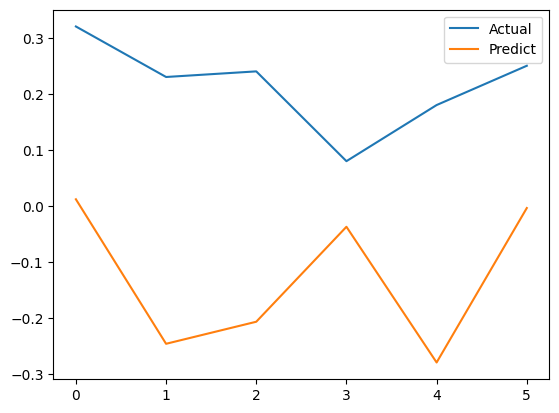

In [11]:
actual_hike = np.array(df_forecast['Rate Hike'])
plt.plot(actual_hike, label = 'Actual')
plt.plot(fed_prediction, label = 'Predict')
plt.legend()
plt.show()

# Import GridSearchCV to hypertune parameters
- Random Forest
- XGBoost (Ensemble method)
- MLP Regressor

## 1. Random Forest

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
param_grid_rf = {'n_estimators': [50,100,200],
             'max_depth': [3,6,10],
             'min_samples_split': [2,5,10],
             'min_samples_leaf': [1,2,4],
             'max_features':['auto', 'sqrt', 'log2'],
             'bootstrap': [True, False]}

In [14]:
grid_regressor = RandomForestRegressor()
grid_search = GridSearchCV(grid_regressor, param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=aut

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=auto, m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=sq

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=log2, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=au

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_featur

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_featu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_fea

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_featur

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_featu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_featu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_fe

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_feat

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_fe

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_featur

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_featu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_feat

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_fea

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_feat

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_fea

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_feature

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_feat

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_fea

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_featu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_featur

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_featur

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_featu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, max_feat

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, ma

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=10,

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [3, 6, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [15]:
best_rf = grid_search.best_estimator_
best_score = grid_search.best_score_
print(best_rf,  best_score)


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=50) 0.22050387533793528


Use best random forest found in Gridsearch

In [16]:
y_pred = best_rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE: ', mse)
print('R2: ', r2)
best_prediction_rf = model.predict(forecast)

MSE:  0.009387123321859968
R2:  0.6238067044772382


Plotting Actual vs Prediction

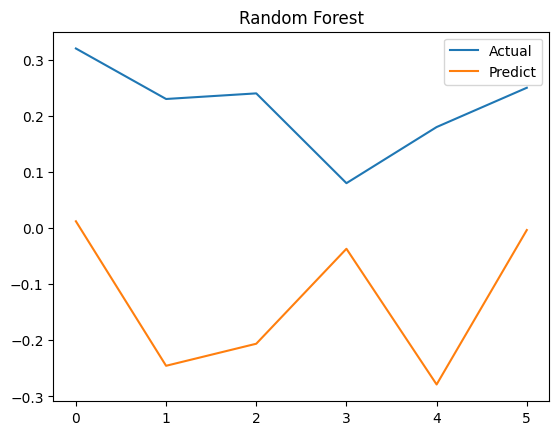

In [17]:
actual_hike = np.array(df_forecast['Rate Hike'])
plt.plot(actual_hike, label = 'Actual')
plt.plot(best_prediction_rf, label = 'Predict')
plt.title('Random Forest')
plt.legend()
plt.show()

## 2. XGBoost

In [18]:
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1],
    'gamma': [0, 0.1, 0.2]
}

In [19]:
grid_regressor = XGBRegressor()

Use Randomised Search algo to speed up model optimisation

In [20]:
from sklearn.model_selection import RandomizedSearchCV
grid_search = RandomizedSearchCV(grid_regressor, param_grid_xgb, cv=5, n_iter = 200, scoring = 'r2', n_jobs=-1)
grid_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 500],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring='r2')

In [21]:
best_xgb = grid_search.best_estimator_
print(grid_search.best_estimator_)
print(grid_search.best_score_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
0.22098141812393263


In [22]:
y_pred = best_xgb.predict(x_test)
best_prediction_xgb = best_xgb.predict(forecast)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE: ', mse)
print('R2: ', r2)

MSE:  0.007048538632650442
R2:  0.7175265642178781


Plotting Actual vs Prediction

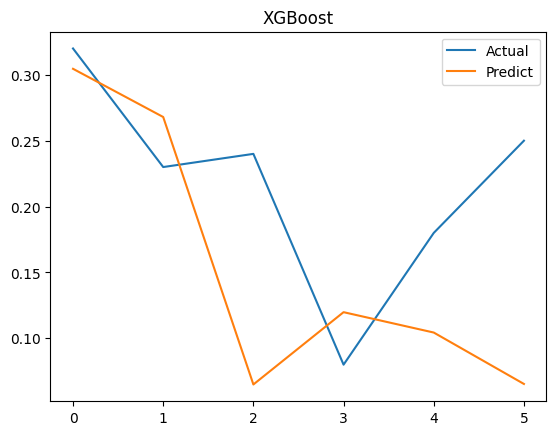

In [23]:
plt.plot(actual_hike, label = 'Actual')
plt.plot(best_prediction_xgb, label = 'Predict')
plt.title('XGBoost')
plt.legend()
plt.show()

## MLP Regressor (Neural network)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Instead of directly feeding a grid search, try cleaning up the data using pipeline function

In [25]:
param_grid_mlp = {
    'mlpregressor__hidden_layer_sizes': [(32,), (64,), (32, 32), (64, 32), (64, 64)],
    'mlpregressor__activation': ['relu', 'tanh', 'logistic'],
    'mlpregressor__solver': ['adam', 'sgd'],
    'mlpregressor__alpha': [0.0001, 0.001, 0.01, 0.1],
    'mlpregressor__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'mlpregressor__learning_rate_init': [0.0001, 0.001, 0.01],
    'mlpregressor__max_iter': [200, 300, 500]
}

In [26]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlpregressor', MLPRegressor())
])

In scoring metrics, neg_mean_squared_error means to minimize MSE. Could use other scoring metrics such as r2 etc.

In [27]:
from sklearn.model_selection import RandomizedSearchCV
grid_search = RandomizedSearchCV(pipeline, param_grid_mlp,cv=5, n_iter = 200, scoring = 'neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('mlpregressor', MLPRegressor())]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'mlpregressor__activation': ['relu',
                                                                     'tanh',
                                                                     'logistic'],
                                        'mlpregressor__alpha': [0.0001, 0.001,
                                                                0.01, 0.1],
                                        'mlpregressor__hidden_layer_sizes': [(32,),
                                                                             (64,),
                                                                             (32,
                                                                              32),
                                                                             (64,
                                                                              32),
                                                                             (64,
                                                                              64)],
                                        'mlpregressor__learning_rate': ['constant',
                                                                        'invscaling',
                                                                        'adaptive'],
                                        'mlpregressor__learning_rate_init': [0.0001,
                                                                             0.001,
                                                                             0.01],
                                        'mlpregressor__max_iter': [200, 300,
                                                                   500],
                                        'mlpregressor__solver': ['adam',
                                                                 'sgd']},
                   scoring='neg_mean_squared_error')

### From my run, this model results in the highest accuracy 
P.S Documented here since this MLP takes the longest time to search, each run will return different results
- Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', hidden_layer_sizes=(64, 32),
                              learning_rate='invscaling',
                              learning_rate_init=0.01, max_iter=500))])

- Best score of grid search:  -0.026833462985364716
- Prediction:  [0.37219434 0.31414798 0.32389258 0.26077962 0.06901211 0.10756939]

In [28]:
best_mlp = grid_search.best_estimator_
print(best_mlp)
print('Best score of grid search: ', grid_search.best_score_)
y_pred = best_mlp.predict(x_test)
best_prediction_mlp = best_mlp.predict(forecast)
print('Prediction: ',best_prediction_mlp)
mse_lr = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE: ', mse_lr)
print('R2: ', r2)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', alpha=0.01,
                              hidden_layer_sizes=(64, 32),
                              learning_rate_init=0.01, max_iter=300))])
Best score of grid search:  -0.027433832818396574
Prediction:  [0.14946574 0.11438493 0.04908479 0.00401115 0.00591756 0.38954495]
MSE:  0.015880490865979823
R2:  0.36358200605717095


Plotting Actual vs Prediction

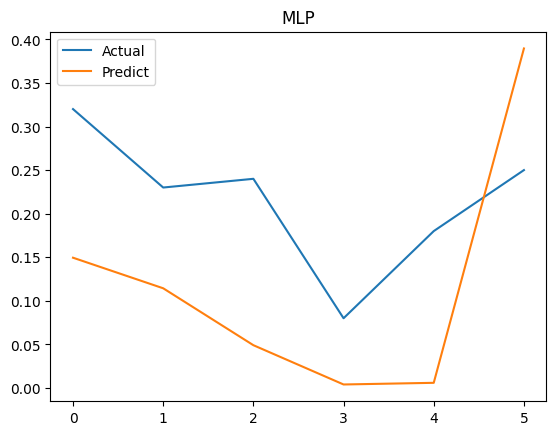

In [29]:
plt.plot(actual_hike, label = 'Actual')
plt.plot(best_prediction_mlp, label = 'Predict')
plt.title('MLP')
plt.legend()
plt.show()

## Residual comparisons

Text(0.5, 1.0, 'Residuals comparisons among models')

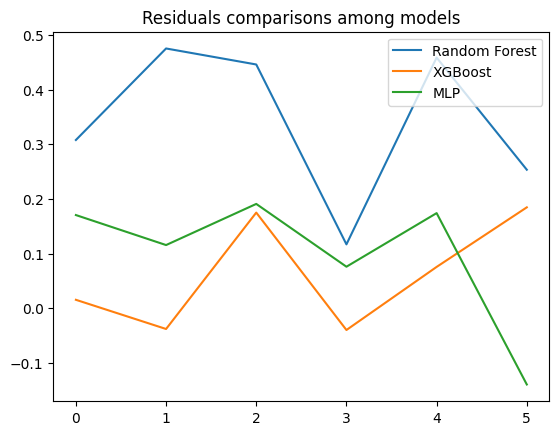

In [30]:
residual_rf = actual_hike - best_prediction_rf
residual_xgb = actual_hike - best_prediction_xgb
residual_mlp = actual_hike - best_prediction_mlp
plt.plot(residual_rf, label='Random Forest')
plt.plot(residual_xgb, label='XGBoost')
plt.plot(residual_mlp, label='MLP')
plt.legend()
plt.title('Residuals comparisons among models')

## Further analysis on Fed rate hike componenets

### Data preparation

Lets try to add more components in our regression model on top of the current economic indicators. Since the Fed would also monitor the market performance (e.g. credit crunch...) in global macros, we would add these in our models:
- Equity index performance (Nasdaq, S&P 500) in beginning of the month
- VIX, BoA OAS performance in beginning of the month

In [31]:
import yfinance as yf
index_list = ['^VIX','^MOVE', '^GSPC', '^IXIC']
indices = yf.Tickers(index_list)
df_indices = pd.DataFrame(indices.history(start='2000-02-01', end='2023-05-20')['Close'])
print(df_indices)

[*********************100%***********************]  4 of 4 completed
                  ^GSPC         ^IXIC       ^MOVE       ^VIX
Date                                                        
2000-02-01  1409.280029   4051.979980         NaN  23.450001
2000-02-02  1409.119995   4073.959961         NaN  23.120001
2000-02-03  1424.969971   4210.979980         NaN  22.010000
2000-02-04  1424.369995   4244.140137         NaN  21.540001
2000-02-07  1424.239990   4321.770020         NaN  22.790001
...                 ...           ...         ...        ...
2023-05-15  4136.279785  12365.209961  127.889999  17.120001
2023-05-16  4109.899902  12343.049805  130.300003  17.990000
2023-05-17  4158.770020  12500.570312  120.779999  16.870001
2023-05-18  4198.049805  12688.839844  122.500000  16.049999
2023-05-19  4191.979980  12657.900391  127.510002  16.809999

[5863 rows x 4 columns]


Tidy up yahoo finance data
- Resample daily entries to monthly entries
- Drop NA data (^MOVE data available 2022-11-01 onwards)

In [32]:
df_indices.index = pd.to_datetime(df_indices.index)
df_indices = df_indices.resample('MS').first()
df_indices = df_indices.dropna().reset_index()
col_names = ['Date', 'S&P500', 'Nasdaq', 'MOVE', 'VIX']
df_indices.columns = col_names
print(df_indices)

          Date       S&P500        Nasdaq        MOVE        VIX
0   2002-11-01   900.960022   1360.699951  120.209999  29.299999
1   2002-12-01   934.530029   1484.780029  127.519997  27.459999
2   2003-01-01   909.030029   1384.849976  130.869995  25.389999
3   2003-02-01   860.320007   1323.790039  109.120003  31.020000
4   2003-03-01   834.809998   1320.290039  101.760002  30.430000
..         ...          ...           ...         ...        ...
242 2023-01-01  3824.139893  10386.980469  129.970001  22.900000
243 2023-02-01  4119.209961  11816.320312   97.330002  17.870001
244 2023-03-01  3951.389893  11379.480469  121.080002  20.580000
245 2023-04-01  4124.509766  12189.450195  138.169998  18.549999
246 2023-05-01  4167.870117  12212.599609  128.179993  16.080000

[247 rows x 5 columns]


In [33]:
df1['Date'] = pd.to_datetime(df1['Date'])

Merge 2 dataframes together

In [34]:
df2 = pd.merge(df1,df_indices, on='Date', how = 'outer')
df2 = df2.dropna()
print(df2)

          Date  Fed Funds  Rate Hike  Core inflation (YoY % chg)   
33  2002-11-01       1.34      -0.41                       0.020  \
34  2002-12-01       1.24      -0.10                       0.022   
35  2003-01-01       1.24       0.00                       0.024   
36  2003-02-01       1.26       0.02                       0.026   
37  2003-03-01       1.25      -0.01                       0.030   
..         ...        ...        ...                         ...   
275 2023-01-01       4.33       0.23                       0.065   
276 2023-02-01       4.57       0.24                       0.064   
277 2023-03-01       4.65       0.08                       0.060   
278 2023-04-01       4.83       0.18                       0.050   
279 2023-05-01       5.08       0.25                       0.049   

     Nonfarm payroll change (MoM chg in thousand)  Unemployment (YoY % chg)   
33                                          123.0                     0.057  \
34                       

Lets save copy this dataframe to excel to backup

In [35]:
reg2_data = wb.sheets[1]
reg2_data.range("A1").value = df2

### Regression preparation (Using MLP best model)
Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', hidden_layer_sizes=(64, 32),
                              learning_rate='invscaling',
                              learning_rate_init=0.01, max_iter=500))])

Split the a number rows for forecasting usages (default as 6)

In [36]:
forecast_number = 6
df2_training = df2[:-forecast_number]
df2_forecast = df2[-forecast_number:]

Run test splits and fit the model (best_mlp)

In [37]:
index_indicators = ['MOVE', 'VIX', 'S&P500', 'Nasdaq']
combined_indicators = econ_indicators + index_indicators
x2 = df2_training[combined_indicators]
y2 = df2_training['Rate Hike']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2)

### Model Optimisation
Fit the model in a destined iteration, and measure its statistical significance

In [38]:
from sklearn.base import clone

In [39]:
models_performance = {}
iterations = 200
scaler = best_mlp.named_steps['scaler']
mlp_regressor = best_mlp.named_steps['mlpregressor']

for i in range(iterations):
    new_mlp_regressor = MLPRegressor(activation=mlp_regressor.activation,
                                      alpha=mlp_regressor.alpha,
                                      hidden_layer_sizes=mlp_regressor.hidden_layer_sizes,
                                      learning_rate=mlp_regressor.learning_rate,
                                      learning_rate_init=mlp_regressor.learning_rate_init,
                                      max_iter=mlp_regressor.max_iter,
                                      random_state=None)

    # Create a new pipeline with the new MLPRegressor
    new_pipeline = Pipeline(steps=[('scaler', scaler),
                                   ('mlpregressor', new_mlp_regressor)])

    new_pipeline.fit(x_train2, y_train2)
    y_pred = new_pipeline.predict(x_test2)
    mse = mean_squared_error(y_test2, y_pred)
    r2 = r2_score(y_test2, y_pred)

    # Store the model based on equal weight in r2 and mse
    models_performance[i] = {'model': new_pipeline, 'r2': r2, 'mse': mse, 'score':r2*1 + mse*-1}

# Find the best model based on composite score in r2 and mse
best_model_index = max(models_performance, key=lambda x: models_performance[x]['score'])
best_mlp_optimised = models_performance[best_model_index]['model']

# Calculate the MSE for the best model
y_pred_best = best_mlp_optimised.predict(x_test2)
mse_best = mean_squared_error(y_test2, y_pred_best)
r2_best = r2_score(y_test2, y_pred_best)

print("Best model index:", best_model_index)
print("Best model:", best_mlp_optimised)
print("Best MSE:", mse_best)
print("Best R2:", r2_best)

Best model index: 182
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', alpha=0.01,
                              hidden_layer_sizes=(64, 32),
                              learning_rate_init=0.01, max_iter=300))])
Best MSE: 0.004350250048773937
Best R2: 0.8287005391226177


Using unseen data for model to make forecasts

In [40]:
forecast2 = df2_forecast[combined_indicators]
best_prediction2_mlp = np.array(best_mlp_optimised.predict(forecast2))
print(best_prediction2_mlp)

[0.30186854 0.280288   0.10064188 0.14765204 0.11314483 0.08549402]


Plot the actual hikes vs predicted hikes from best MLP

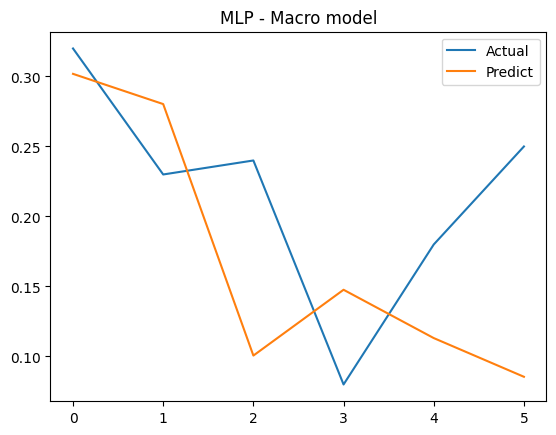

In [41]:
plt.plot(actual_hike, label = 'Actual')
plt.plot(best_prediction2_mlp, label = 'Predict')
plt.title('MLP - Macro model')
plt.legend()
plt.show()

### Factors analysis

Optimise the first model for fair comparison (Soely using economic indicators)

In [42]:
models_performance = {}
iterations = 200
scaler = best_mlp.named_steps['scaler']
mlp_regressor = best_mlp.named_steps['mlpregressor']

for i in range(iterations):
    new_mlp_regressor = MLPRegressor(activation=mlp_regressor.activation,
                                      alpha=mlp_regressor.alpha,
                                      hidden_layer_sizes=mlp_regressor.hidden_layer_sizes,
                                      learning_rate=mlp_regressor.learning_rate,
                                      learning_rate_init=mlp_regressor.learning_rate_init,
                                      max_iter=mlp_regressor.max_iter,
                                      random_state=None)

    # Create a new pipeline with the new MLPRegressor
    new_pipeline = Pipeline(steps=[('scaler', scaler),
                                   ('mlpregressor', new_mlp_regressor)])

    new_pipeline.fit(x_train, y_train)
    y_pred = new_pipeline.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the model based on equal weight in r2 and mse
    models_performance[i] = {'model': new_pipeline, 'r2': r2, 'mse': mse, 'score':r2*1 + mse*-1}

# Find the best model based on composite score in r2 and mse
best_model_index = max(models_performance, key=lambda x: models_performance[x]['score'])
best_mlp_optimised = models_performance[best_model_index]['model']

# Calculate the MSE for the best model
y_pred_best = best_mlp_optimised.predict(x_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
forecast = df_forecast[econ_indicators]
best_prediction_mlp = np.array(best_mlp_optimised.predict(forecast))

print("Best model index:", best_model_index)
print("Best model:", best_mlp_optimised)
print("Best MSE:", mse_best)
print("Best R2:", r2_best)

Best model index: 157
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', alpha=0.01,
                              hidden_layer_sizes=(64, 32),
                              learning_rate_init=0.01, max_iter=300))])
Best MSE: 0.007004359161671317
Best R2: 0.7192970768885047


Compare residuals between using 1. Economic indicators and 2. Economic indicators + Global indices

Text(0.5, 1.0, 'Residual Plot')

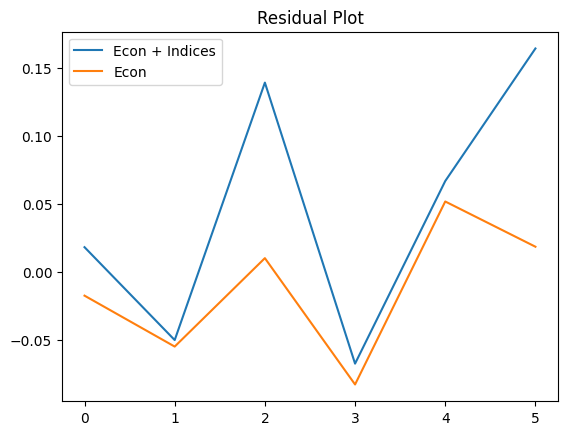

In [44]:
# Only using economic indicators
residual_mlp = actual_hike - best_prediction_mlp

# Using economic indicators + global indices
residual_mlp2 = actual_hike - best_prediction2_mlp
plt.plot(residual_mlp2, label = 'Econ + Indices')
plt.plot(residual_mlp, label = 'Econ')
plt.legend()
plt.title('Residual Plot')